In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

import sys
sys.path.append("../../../../")

from src.difsched.agents.DiffusionQL.DQL_Q_esmb import DQL_Q_esmb as Agent
from src.difsched.utils.DataSampler import ReplayBuffer
from toy_mdp_helper import generate_dataset, evaluate_diffusionQ, extract_deterministic_policy, visualize_policy_heatmap

In [3]:
hyperparams = {
    'N_diffusion_steps':30,
    'schedule_type': "vp",
    'abs_action_max': 1.0,
    'gamma': 0.99,
    'lr': 5e-3,
    'decay_lr': False,
    'weight_decay': 0.001,
    'num_critics': 2,
    'lcb_coef': 0.0,
    'q_sample_eta': 1.0,
    'weight_entropy_loss': 0.0,
    'weight_q_loss': 1.0,
    'approximate_action': True,
    'ema_tau': 0.005,
    'ema_period': 20,
    'ema_begin_update': 1000,
    'layer_norm': False,
    'device': 'cuda',
}


N_s = 10
N_a = 10
LEN_dataset = 5000

rb_capacity = LEN_dataset
dataset, policy_mdp, P, R = generate_dataset(LEN_dataset, N_s, N_a, seed=995)

data_sampler = ReplayBuffer(capacity=rb_capacity, device=hyperparams['device'])
data_sampler.add(dataset)
print(len(data_sampler))

print(R)
print(policy_mdp)


Value Iteration: 100%|██████████| 1000/1000 [00:00<00:00, 1009.07it/s, V=-87.638921]
                                                                                       

5000
[[0.36529473 0.33038681 0.10620039 0.60942595 0.46317416 0.87519138
  0.859934   0.43951974 0.07658387 0.55867161]
 [0.47649886 0.5518546  0.09345876 0.47372247 0.46726509 0.22616964
  0.13531992 0.58661913 0.36148545 0.66451086]
 [0.14260466 0.66248199 0.71877577 0.12349261 0.65023966 0.07525486
  0.90119159 0.89878138 0.99937701 0.40205146]
 [0.68262961 0.18915149 0.53016662 0.73463697 0.1689499  0.48889537
  0.02553294 0.5763825  0.56285711 0.6558536 ]
 [0.37928779 0.02233942 0.75530224 0.46754421 0.4790499  0.23888401
  0.16763018 0.97943109 0.19422053 0.65710252]
 [0.0599216  0.5351665  0.20710911 0.20271593 0.24860664 0.96076272
  0.63269673 0.27869998 0.1939712  0.13538802]
 [0.36840029 0.77901263 0.94862485 0.62836922 0.54056518 0.89171565
  0.03780786 0.30227285 0.51608898 0.55511329]
 [0.33173178 0.45225676 0.03474664 0.23290379 0.70865918 0.79848486
  0.00554318 0.4580984  0.7172753  0.20760413]
 [0.94590482 0.12740326 0.21954574 0.07881047 0.03874216 0.36118237
  0.794

In [5]:
print(f"Expert's Reward:{np.mean(dataset['rewards'])}")

modelFolder = f'../../../../data/results/examples/mdp'

eta = 0.1
agent = Agent(state_dim=1, action_dim=1, **hyperparams)
iterations = 200
batch_size = 100
N_episodes = 25
best_reward = -np.inf
meta_metrics = {'reward': []}
for i in range(N_episodes):
      metrics = agent.train(data_sampler, iterations, batch_size, tqdm_pos=0)
      policy_DQ, _ = extract_deterministic_policy(agent, N_s, N_a, sample_method="EAS", N_sample=10, eta=eta)
      reward_DQ, _ = evaluate_diffusionQ(agent, R, P, N_s, N_a, N_iter=100, sample_method="EAS", N_sample=10, eta=eta)
      if reward_DQ > best_reward:
            best_reward = reward_DQ
            agent.save_model(modelFolder, "best")
            print(f"New best reward: {best_reward}")
      meta_metrics['reward'].append(reward_DQ)
      if i % 5 == 0:
            print(f"Iteration {i}, Ld: {np.mean(metrics['Ld'])}, " + 
                  f"Lq: {np.mean(metrics['Lq'])}, " + 
                  f"Le: {np.mean(metrics['Le'])}, " + 
                  f"loss_Q: {np.mean(metrics['loss_Q'])}")
            print(f"Policy: {policy_mdp}->{policy_DQ}")
            print(f"Reward: {reward_DQ}")
     

Expert's Reward:0.874268878606705


  0%|          | 0/200 [00:00<?, ?it/s]

New best reward: 0.3976580436808692
Iteration 0, Ld: 0.6606204679608345, Lq: 0.8494061237759888, Le: -1.455905202627182, loss_Q: 0.06269337687641383
Policy: [5 9 8 3 7 5 2 5 8 2]->[5, 5, 4, 4, 4, 4, 4, 4, 3, 3]
Reward: 0.3976580436808692


KeyboardInterrupt: 

Extracting deterministic policy:   0%|          | 0/10 [00:00<?, ?it/s]

Plot saved to: fig04_policy_heatmap.png


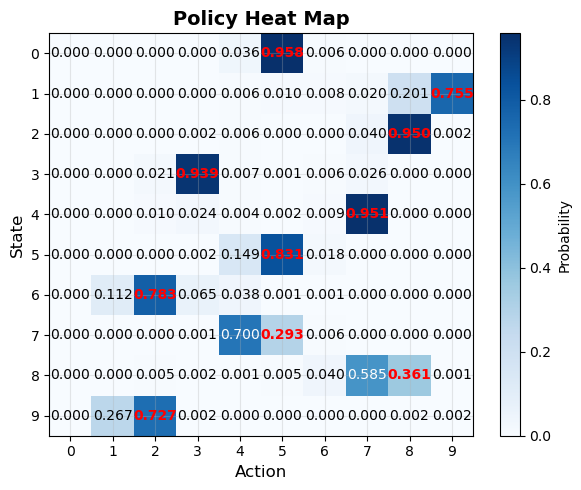

In [ ]:
agent.load_model(modelFolder, "best")
eta = 1.0
sample_method = "EAS"   
_, frequency_DQ = extract_deterministic_policy(agent, N_s, N_a, sample_method=sample_method, N_sample=50, N_sampling=1000, eta=eta)
#reward_DQ, _ = evaluate_diffusionQ(agent, R, P, N_s, N_a, N_iter=1000, sample_method=sample_method, N_sample=50, eta=eta)
#print(f"Reward: {reward_DQ}")
visualize_policy_heatmap(frequency_DQ, policy_mdp, title="Policy Heat Map", save_path="fig04_policy_heatmap.png", figsize=(6, 5))

In [ ]:
#reward_DQ, _ = evaluate_diffusionQ(agent, R, P, N_s, N_a, N_iter=1000, sample_method="EAS", N_sample=10)  
#print(f"Reward: {reward_DQ}")